In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [35]:
# Datensätze laden
df_analysis = pd.read_csv('df_camping_analysis.csv', encoding='utf-8')
df_analysis_cor = pd.read_csv('df_camping_analysis_no_cor.csv', encoding='utf-8')
df_analysis_outl = pd.read_csv('df_camping_analysis_no_outl.csv', encoding='utf-8')
df_analysis_dopp = pd.read_csv('df_camping_analysis_dopp.csv', encoding='utf-8')

In [20]:
# Lineare Regression - Modell mit Train-Test Split
def lineare_regression_metrics(model, df):
    X = df.drop(columns=['Preis'])
    y = df['Preis']

    # Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modell trainieren
    model.fit(X_train, y_train)

    # Vorhersagen
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metriken berechnen
    metrics = {
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred)
    }

    # Cross-Validation-Metriken hinzufügen
    cross_val_results = cross_val_metrics(model, X, y)
    metrics.update(cross_val_results)

    # Ausgeben von Metriken, Feature Importance Parameter
    return metrics, X_test, y_test, y_test_pred

# Random Forest - Modell mit Cross-Validation
def cross_val_metrics(model, X, y):
    r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    return {
        'cross_val_r2_mean': r2_scores.mean(),
        'cross_val_r2_std': r2_scores.std(),
        'cross_val_mse_mean': -mse_scores.mean(),
        'cross_val_mse_std': mse_scores.std()
    }


# Modell definieren
model = LinearRegression()

# Metriken für beide Datensätze berechnen
metrics_df_analysis, X_test_analysis, y_test_analysis, y_test_pred_analysis,  = lineare_regression_metrics(model, df_analysis)
metrics_df_analysis_cor, X_test_cor, y_test_cor, y_test_pred_cor,  = lineare_regression_metrics(model, df_analysis_cor)
metrics_df_analysis_outl, X_test_outl, y_test_outl, y_test_pred_outl,  = lineare_regression_metrics(model, df_analysis_outl)
metrics_df_analysis_dopp, X_test_dopp, y_test_dopp, y_test_pred_dopp,  = lineare_regression_metrics(model, df_analysis_dopp)

# Zusammenführen der Ergebnisse in einem DataFrame und ausgeben
results = pd.DataFrame([metrics_df_analysis, metrics_df_analysis_cor, metrics_df_analysis_outl, metrics_df_analysis_dopp], index=['df_analysis', 'df_analysis_cor', 'df_analysis_outl', 'df_analysis_dopp'])

results

,train_r2,test_r2,train_mse,test_mse,cross_val_r2_mean,cross_val_r2_std,cross_val_mse_mean,cross_val_mse_std
df_analysis,0.602011,0.468810,89.882207,77.237845,0.188342,0.205532,151.241297,53.189600
df_analysis_cor,0.602011,0.468806,89.882258,77.238418,0.188342,0.205532,151.241297,53.189600
df_analysis_outl,0.639089,0.447319,43.847688,76.502005,0.334182,0.113821,80.189123,12.346765
df_analysis_dopp,0.609683,0.588106,47.367048,57.480293,0.560865,0.058400,53.988087,6.036542


# Hyperparameter-Tuning

In [36]:
X = df_analysis_dopp.drop(columns=['Preis'])
y = df_analysis_dopp['Preis']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Ridge

In [37]:
ridge = Ridge()
parameters = {'alpha': [0.1, 1, 10, 100]}
ridge_regressor = GridSearchCV(ridge, parameters, cv=6)
ridge_regressor.fit(X, y)

print("Bester Ridge Regression Parameter:", ridge_regressor.best_params_)

Bester Ridge Regression Parameter: {'alpha': 1}


In [38]:
best_ridge = Ridge(alpha=ridge_regressor.best_params_['alpha'])
best_ridge.fit(X_train, y_train)
print("Ridge Regression R^2 Score:", best_ridge.score(X_test, y_test))

Ridge Regression R^2 Score: 0.5885113489980933


### Lasso

In [39]:
lasso = Lasso()
parameters = {'alpha': [0.01, 0.1, 1]}
lasso_regressor = GridSearchCV(lasso, parameters, cv=6)
lasso_regressor.fit(X, y)

print(f"Bester Lasso Regression Parameter:", lasso_regressor.best_params_)


Bester Lasso Regression Parameter: {'alpha': 0.01}


In [40]:
best_lasso = Lasso(alpha=lasso_regressor.best_params_['alpha'])
best_lasso.fit(X_train, y_train)
print("Lasso Regression R^2 Score:", best_lasso.score(X_test, y_test))

Lasso Regression R^2 Score: 0.5877085506623483


# Interpretieren

In [26]:
def linear_regression_metrics(df):
    X = df.drop(columns=['Preis'],axis = 1)
    y = df['Preis']

    # Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalisierung (Standardisierung) der numerischen Features
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    X[numeric_features] = scaler.fit_transform(X[numeric_features])

    # Modell trainieren
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Metriken berechnen
    metrics = {
        'achsabschnitt': model.intercept_,
        'koeffizienten': model.coef_,
        'name': X.columns
    }

    return metrics

# Berechnen der Metriken für den spezifischen Datensatz
metrics_df_analysis_dopp = linear_regression_metrics(df_analysis_dopp)

# Ausgabe des spezifischen Bereichs
metrics = metrics_df_analysis_dopp
print(f"Achsabschnitt: {metrics['achsabschnitt']}")
print("Koeffizienten:")

feature_coefficients = zip(metrics['name'], metrics['koeffizienten'])

# Sortieren der Merkmale
sorted_features = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

for feature, coef in sorted_features:
    print(f"{feature}: {coef}")


Achsabschnitt: 24.08421049252327
Koeffizienten:
Hallenbad: 13.651829413606077
Region Tessin: 9.354602738453872
grosser Platz (>110 m2): 9.064724214097257
Stellplatz am Wasser: 7.483625150262117
mittlerer Platz  (~100 m2): 6.786101649603317
Nebensaison: -6.043119439833174
Region Berner-Mitelland: 5.963419773293303
Unterhaltungsprogramm: -5.026732048232229
Tennis: -4.141970939275883
Aufenthaltsraum: -3.388090528838399
Region Graubuenden: 3.2353103283537576
Bootsvermietung: 2.9133422134986913
Öffnungszeit[%]: -2.6693158463642246
weiter Unterküfte: 2.3718533302624163
Wandern: 2.209301972930446
Region Berner-Oberland: 1.9838920883075208
Babypool: -1.7884859598654903
Gastronomie: 1.7742884065893372
Mitgliedschaften: 1.684529692843157
Bahnhof: -1.6433129302839988
Region Waadt-Genfersee: 1.635897947087194
Region Zuerich: 1.6112524293245956
Region Zentralschweiz: 1.571680766205767
Sternebewertung: 1.3343914863284323
Region Ostschweiz: 1.1952160260231737
Busstation: 1.1248707111432048
Spielplatz

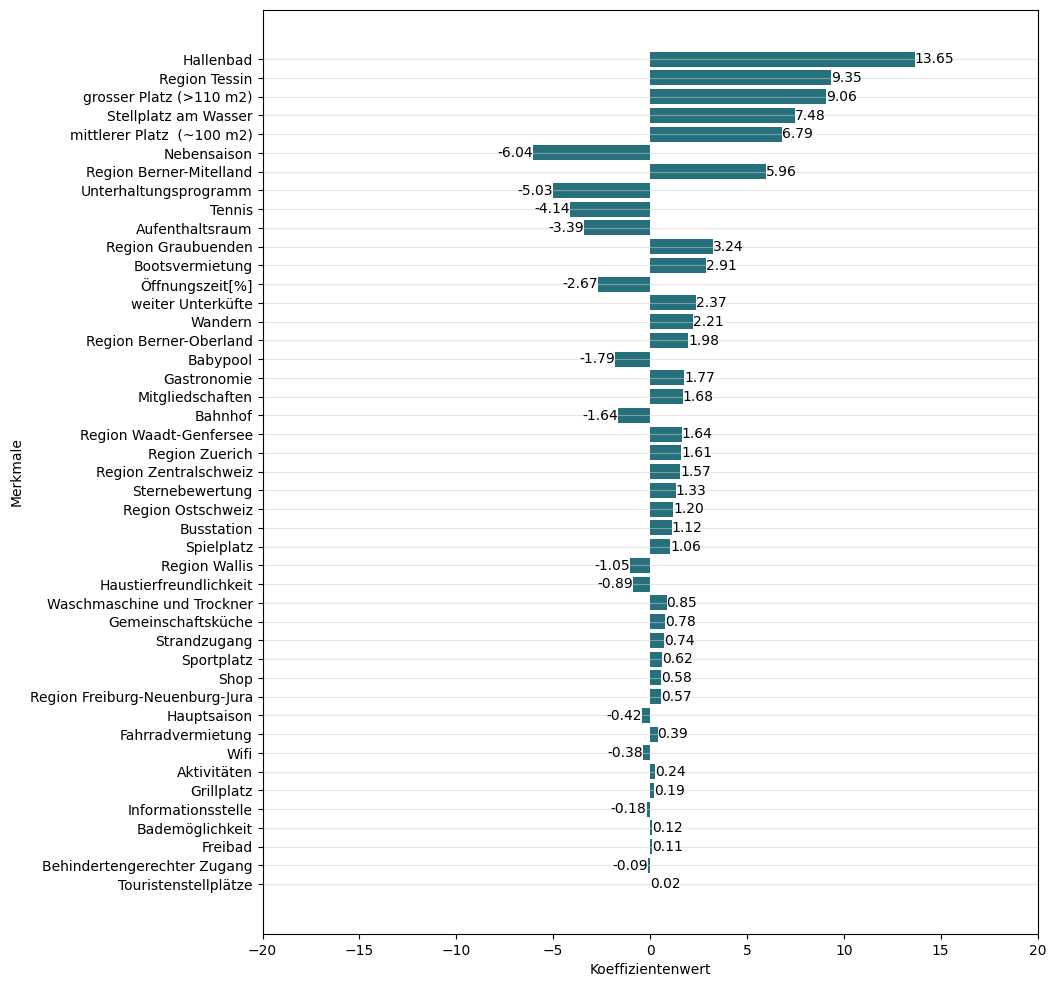

In [27]:
# visuelle Darstellung der Koeffizienten
import matplotlib.pyplot as plt

# Koeffizienten und Feature-Namen
koeffizienten = metrics['koeffizienten']
merkmale = metrics['name']

# Koeffizienten und Merkmale kombinieren
merkmale_koeffizienten = list(zip(merkmale, koeffizienten))

# Merkmale nach dem absoluten Wert der Koeffizienten sortieren
merkmale_sort = sorted(merkmale_koeffizienten, key=lambda x: abs(x[1]), reverse=True)

# Features und Koeffizienten entpacken
namen_sort, koeffizient_sort = zip(*merkmale_sort)

# Barplots erstellen
plt.figure(figsize=(10, 12))
bars = plt.barh(namen_sort, koeffizient_sort, color='#26707C')
plt.xlabel('Koeffizientenwert')
plt.ylabel('Merkmale')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='')
plt.grid(axis='y', alpha=0.5, color='#CFCFCF')

# Werte hinzufügen
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
             ha='left' if width > 0 else 'right', va='center')

plt.xlim(-20, 20)
plt.show()